In [47]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
import scipy
from skimage import data
from skimage import filters, io
import os

## 1.) Intro and Concepts

#### Images are NumPy’s arrays np.ndarray

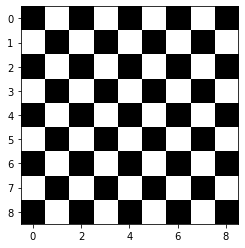

In [3]:
check = np.zeros((9, 9))
check[::2, 1::2] = 1
check[1::2, ::2] = 1
plt.imshow(check, cmap='gray', interpolation='nearest') 
plt.show()

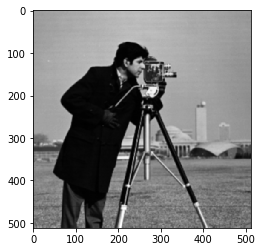

In [13]:
camera = data.camera() # comes from scikit-image library

filtered_camera = filters.gaussian(camera, 1)

plt.imshow(filtered_camera, cmap="gray")
plt.show()

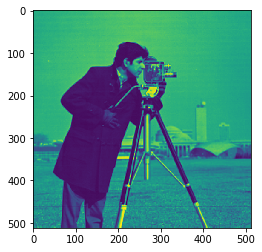

In [14]:
plt.imshow(camera)
plt.show()

In [5]:
camera.dtype

dtype('uint8')

In [6]:
camera.shape

(512, 512)

In [7]:
type(filtered_camera)

numpy.ndarray

## 2.) Color Spaces

#### Color images are of shape (N, M, 3) or (N, M, 4) (when an alpha channel encodes transparency)

(768, 1024, 3)


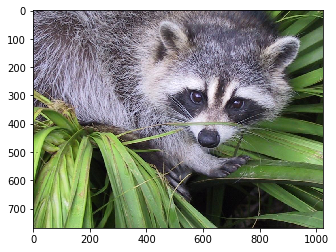

In [19]:
face = scipy.misc.face()
print(face.shape)
plt.imshow(face)
plt.show()

### Excercise 1

#### Open a color image on your disk as a NumPy array.

#### Find a skimage function computing the histogram of an image and plot the histogram of each color channel

#### Convert the image to grayscale and plot its histogram.

In [25]:
blue = face[...,0]
green = face[...,1]
red = face[...,2]

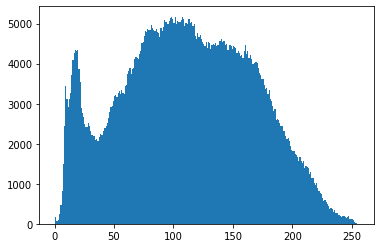

In [33]:
plt.hist(blue.ravel(), 256, [0,256])
plt.show()

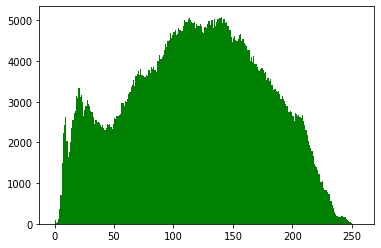

In [35]:
plt.hist(green.ravel(), 256, [0,256], color='g')
plt.show()

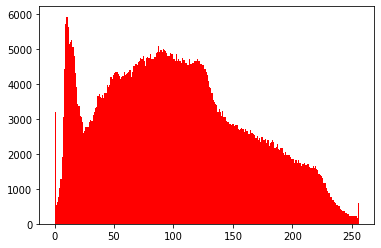

In [34]:
plt.hist(red.ravel(), 256, [0,256], color='r')
plt.show()

#### Redoing excercise with custom image

In [52]:
path = os.getcwd() + "/images/greens.jpg"
img = io.imread(path)

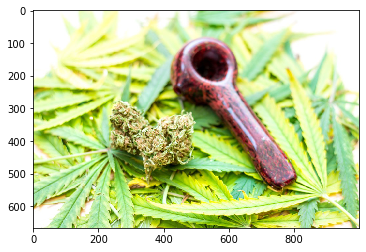

In [54]:
plt.imshow(img)
plt.show()

In [85]:
blue = img[...,0]
green = img[...,1]
red = img[...,2]

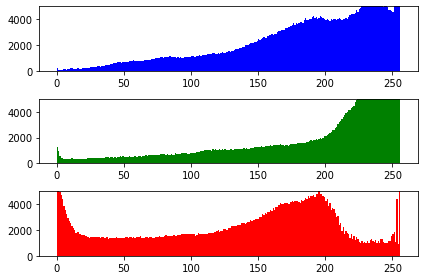

In [93]:
fig, ax = plt.subplots(3)

ax[0].hist(blue.ravel(), 256, [0,256], color='b')
ax[1].hist(green.ravel(), 256, [0,256], color='g')
ax[2].hist(red.ravel(), 256, [0,256], color='r')

ax[0].set_ylim(0,5000)
ax[1].set_ylim(0,5000)
ax[2].set_ylim(0,5000)

plt.tight_layout()

plt.show()

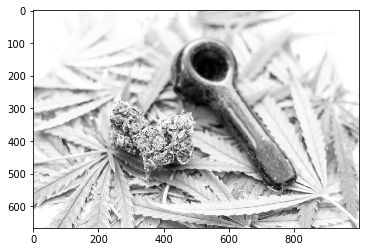

In [95]:
grayImg = io.imread(path, as_gray = True)
plt.imshow(grayImg)
plt.show()

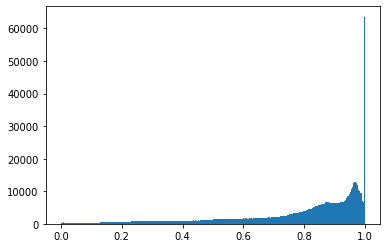

In [111]:
plt.hist(grayImg.ravel(), 256, [0,1])

plt.show()

## 3.) Image Preprocessing / enchancement

#### Goals: denoising, feature (edges) extraction, …